# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.2 MB/s eta 0:00:00


In [ ]:
!mkdir /content/dataset/
!unzip /content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C.zip -d /content/dataset/train3C/
!unzip /content/drive/MyDrive/MaiaSpain/CAD/project/dataset/val3C.zip -d /content/dataset/val3C/
!mkdir -p /content/dataset/test3C/
!tar -xvzf /content/drive/MyDrive/MaiaSpain/CAD/project/dataset/test/test_3c.tgz -C /content/dataset/test3C/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train/mel/mel02103.jpg  
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train/mel/mel01190.jpg  
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train/mel/mel01071.jpg  
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train/mel/mel00900.jpg  
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train/mel/mel00231.jpg  
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train/mel/mel02128.jpg  
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train/mel/mel02644.jpg  
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/datase

# Initialization

In [ ]:
%cd /content/drive/MyDrive/MaiaSpain/CAD/project/

/content/drive/.shortcut-targets-by-id/1fTsBspXCDEVY7q8PyaNkRq-51xfzOyIV/MaiaSpain/CAD/project


In [ ]:
import os
import numpy as np
from torch.utils.data import WeightedRandomSampler
from monai.transforms import (
    Compose, Rand2DElasticd, RandRotate90d, RandFlipd, RandAffined, ScaleIntensityd,
    RandCoarseShuffled, EnsureTyped, LoadImaged, Resized, ToTensord, NormalizeIntensityd
)
from monai.data import PersistentDataset, Dataset, DataLoader
from monai.losses import FocalLoss
from PIL import Image
import torch
from torch import nn, tensor
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, StepLR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, cohen_kappa_score
from tqdm import tqdm
from torchvision import models
from shutil import rmtree
from transformers import DeiTForImageClassification, DeiTConfig
import csv
from torch.nn import functional as F

# Dataloader

In [ ]:
cls_to_idx = {'mel':0, 'bcc':1, 'scc':2}
idx_to_cls = {0:'mel', 1:'bcc', 2:'scc'}

def get_weights(data_path):
  classes = os.listdir(data_path)
  num_samples = {cls: len(os.listdir(os.path.join(data_path, cls))) for cls in classes}
  weights = {cls: (1 / num_samples[cls]) / sum((1 / v for v in num_samples.values())) for cls in classes}
  return weights

def load_from_npz(file_name):
    data = np.load(file_name, allow_pickle=True)
    paths = data['paths']
    features = data['features']
    labels = data['labels']
    return paths, features, labels

def get_data(data_path, cls_weights, embeddings_path=None):
  data = []
  sample_weights = []
  classes = os.listdir(data_path)
  if embeddings_path is not None:
    npz_paths, npz_embeddings, npz_labels = load_from_npz(embeddings_path)
  for cls in classes:
      cls_path = os.path.join(data_path, cls)
      for image_name in os.listdir(cls_path):
          image_path = os.path.join(cls_path, image_name)
          if embeddings_path is not None:
            if image_path.replace('/content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/','/Users/ayaelgebaly/Downloads/maiaUdg/CAD/DLproject/') not in npz_paths:
              continue
            embedding = npz_embeddings[list(npz_paths).index(image_path.replace('/content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/','/Users/ayaelgebaly/Downloads/maiaUdg/CAD/DLproject/'))]
            assert cls_to_idx[cls] == npz_labels[list(npz_paths).index(image_path.replace('/content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/','/Users/ayaelgebaly/Downloads/maiaUdg/CAD/DLproject/'))]
            data.append({'image':image_path, 'label':cls_to_idx[cls], 'embedding':embedding})
          else:
            data.append({'image':image_path, 'label':cls_to_idx[cls]})
          sample_weights.append(cls_weights[cls])
  return data, sample_weights

In [ ]:
base_transforms = [
    LoadImaged('image',ensure_channel_first=True),
    Resized('image',(224, 224)),
    NormalizeIntensityd(['image'])
]

augmentations = [
    ScaleIntensityd('image',0,1),
    Rand2DElasticd('image',prob=0.75, spacing=32, magnitude_range=(1, 4), padding_mode="zeros"),
    RandRotate90d('image',prob=0.75, spatial_axes=[0, 1]),
    RandFlipd('image',prob=0.5, spatial_axis=0),
    RandFlipd('image',prob=0.5, spatial_axis=1),
    RandAffined('image',prob=0.75,rotate_range=(0.75, 0.75),padding_mode="zeros",),
    NormalizeIntensityd('image')
]

train_transform = Compose(base_transforms + augmentations)
val_transform = Compose(base_transforms)

# rmtree('/content/cache/',True)

cls_weights = get_weights("/content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train")
train_data, train_weights = get_data("/content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train", cls_weights, 'dataset/test/google_derm_train3c_embeddings.npz')
val_data, val_weights = get_data("/content/dataset/val3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/val3C/val", cls_weights)

train_dataset = PersistentDataset(data=train_data, transform=train_transform, cache_dir='/content/cache/train')
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=os.cpu_count(), pin_memory=True)
val_dataset = PersistentDataset(data=val_data, transform=val_transform, cache_dir='/content/cache/val')
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=os.cpu_count(), pin_memory=True)

# Visualization

/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-p

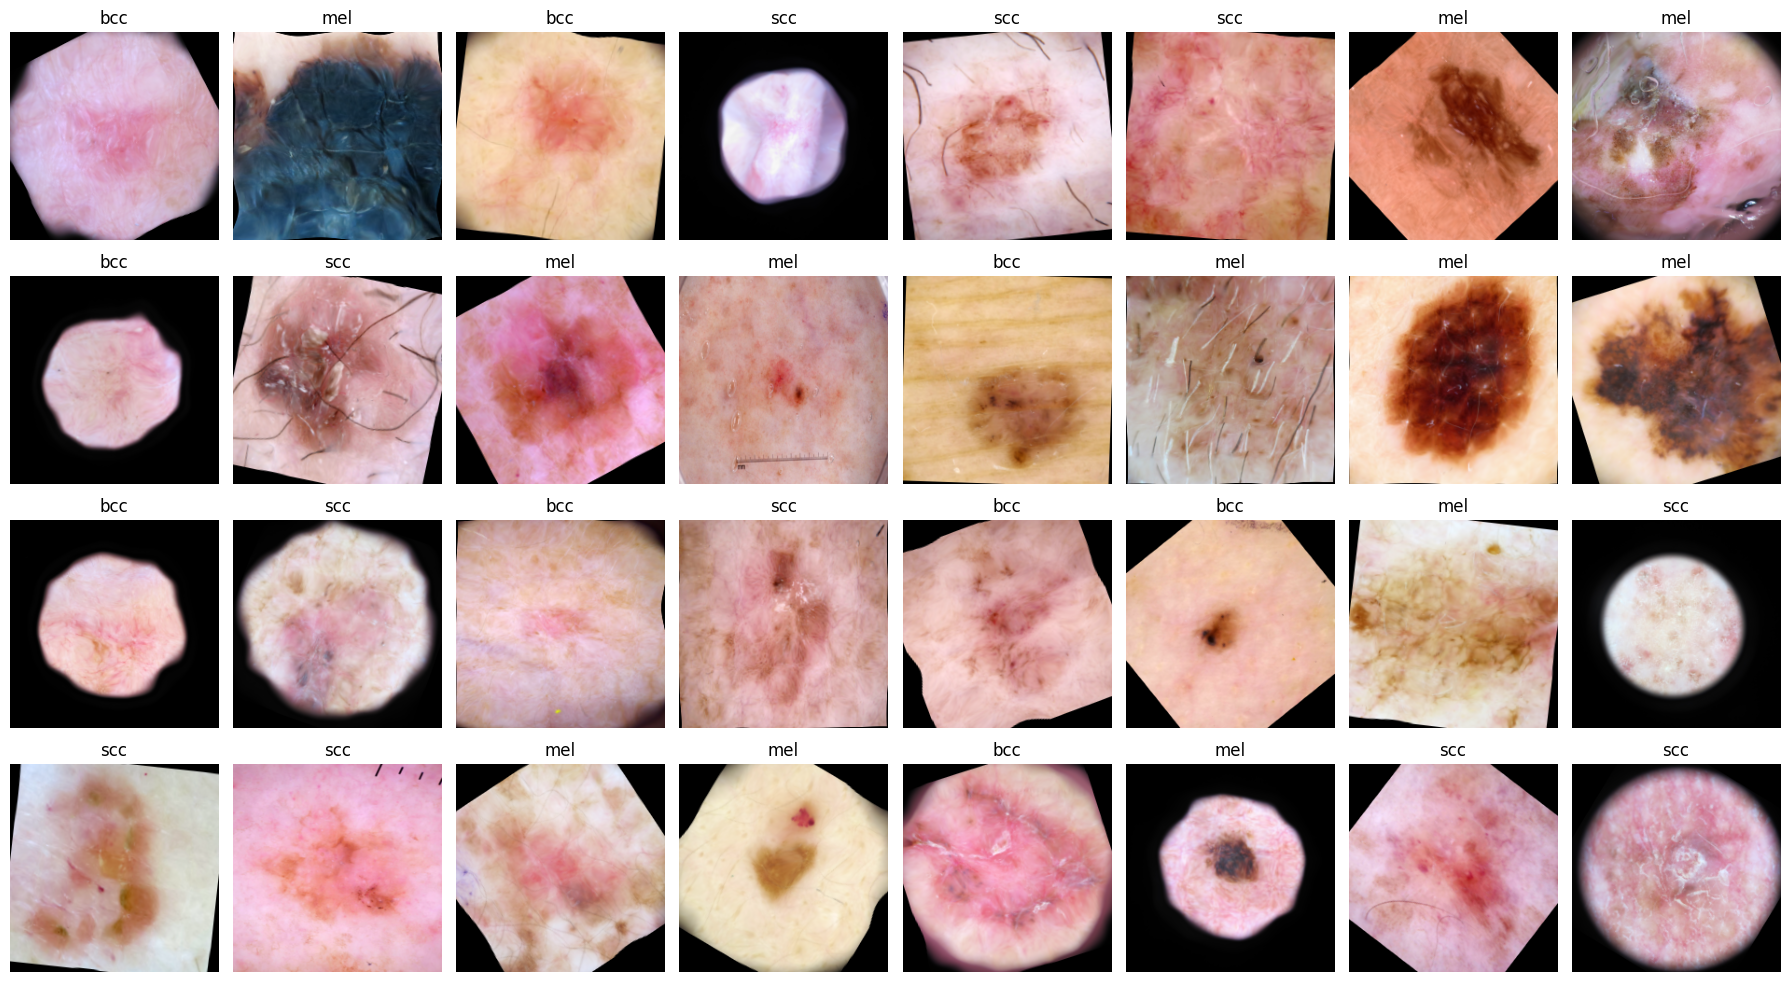

In [ ]:
# import matplotlib.pyplot as plt

# train_loader.dataset.transform.transforms = train_loader.dataset.transform.transforms+(ScaleIntensityd('image',0,1),)
# plt.figure(figsize=(18,10))
# batch = next(iter(train_loader))
# for i in range(32):
#   image, label = batch['image'][i], batch['label'][i]
#   plt.subplot(4,8,i+1)
#   plt.imshow(image.permute(1,2,0).numpy())
#   plt.title(idx_to_cls[label.item()])
#   plt.axis('off')
# plt.tight_layout()
# plt.show()

# Training and Evaluation

In [ ]:
def calculate_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro")
    recall = recall_score(labels, preds, average="macro")
    f1 = f1_score(labels, preds, average="macro")
    kappa = cohen_kappa_score(labels, preds)
    return accuracy, precision, recall, f1, kappa

def train_and_evaluate_model(model, train_loader, val_loader, device, epochs=30, min_delta=0.0001):
    model = model.to(device)
    projector = nn.Sequential(nn.Linear(768, 3072), nn.ReLU(), nn.Linear(3072, 6144), nn.ReLU()).to(device)
    cls_criterion = FocalLoss(to_onehot_y=True, use_softmax=True)
    distill_criterion = nn.KLDivLoss(reduction='batchmean')
    optimizer = torch.optim.AdamW(list(model.parameters()) + list(projector.parameters()), lr=1e-4, weight_decay=1e-4)
    scheduler=StepLR(optimizer, step_size=15, gamma=0.5)
    best_kappa = 0
    save_dir = "models_alberb_3cls_distill/"
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(epochs):
        model.train()
        epoch_cls_loss, epoch_distill_loss = 0, 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            images, labels, gt_embedding = batch['image'].to(device), batch['label'].to(device), batch['embedding'].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs, embedding = outputs.logits, outputs.hidden_states[-1][:, -1, :]
            cls_loss = (3*cls_criterion(outputs, labels))
            distill_loss = distill_criterion(F.log_softmax(projector(embedding), dim=-1), F.softmax(gt_embedding, dim=-1))
            loss = cls_loss + distill_loss
            loss.backward()
            optimizer.step()
            epoch_cls_loss += cls_loss.item()
            epoch_distill_loss += distill_loss.item()
        scheduler.step()

        print(f"Epoch {epoch + 1}/{epochs}, Classification Loss: {epoch_cls_loss / len(train_loader):.6f}, Distill Loss: {epoch_distill_loss / len(train_loader):.6f}")

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch['image'].to(device), batch['label'].to(device)
                outputs = model(images)
                outputs = outputs.logits
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy, precision, recall, f1, kappa = calculate_metrics(all_labels, all_preds)
        cm = confusion_matrix(all_labels, all_preds)
        print(f"Validation Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Kappa: {kappa:.4f}")
        print(f"Confusion Matrix:\n{cm}")

        if kappa > best_kappa + min_delta:
            model_path = os.path.join(save_dir, f"best_model_{kappa:.4f}.pth")
            torch.save(model.state_dict(), model_path)
            if os.path.exists(os.path.join(save_dir, f"best_model_{best_kappa:.4f}.pth")):
              os.remove(os.path.join(save_dir, f"best_model_{best_kappa:.4f}.pth"))
            best_kappa = kappa
            print(f"Model saved to {model_path}")

In [ ]:
from transformers import DeiTForImageClassification, DeiTConfig

config = DeiTConfig.from_pretrained("facebook/deit-base-distilled-patch16-224")
config.num_labels, config.output_hidden_states = 3, True
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", config=config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Experiments

In [ ]:
train_and_evaluate_model(
    model, train_loader, val_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), epochs=100
)

Epoch 1/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 1/100, Classification Loss: 0.243678, Distill Loss: 0.231154


Validation Metrics - Accuracy: 0.8142, Precision: 0.7140, Recall: 0.7919, F1: 0.7268, Kappa: 0.6839
Confusion Matrix:
[[588  47  43]
 [ 35 375  88]
 [  9  14  71]]
Model saved to models_alberb_3cls_distill/best_model_0.6839.pth


Epoch 2/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 2/100, Classification Loss: 0.131578, Distill Loss: 0.153577



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8858, Precision: 0.8178, Recall: 0.8255, F1: 0.8214, Kappa: 0.7957
Confusion Matrix:
[[612  54  12]
 [ 26 450  22]
 [ 20  11  63]]
Model saved to models_alberb_3cls_distill/best_model_0.7957.pth


Epoch 3/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 3/100, Classification Loss: 0.086197, Distill Loss: 0.129027



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8433, Precision: 0.7476, Recall: 0.8409, F1: 0.7700, Kappa: 0.7322
Confusion Matrix:
[[597  59  22]
 [ 19 394  85]
 [  8   6  80]]


Epoch 4/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 4/100, Classification Loss: 0.053644, Distill Loss: 0.107869



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8937, Precision: 0.8232, Recall: 0.8518, F1: 0.8361, Kappa: 0.8110
Confusion Matrix:
[[615  50  13]
 [ 22 450  26]
 [ 15   9  70]]
Model saved to models_alberb_3cls_distill/best_model_0.8110.pth


Epoch 5/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 5/100, Classification Loss: 0.038581, Distill Loss: 0.100450



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9087, Precision: 0.8529, Recall: 0.8574, F1: 0.8550, Kappa: 0.8356
Confusion Matrix:
[[639  30   9]
 [ 33 446  19]
 [ 14  11  69]]
Model saved to models_alberb_3cls_distill/best_model_0.8356.pth


Epoch 6/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 6/100, Classification Loss: 0.043279, Distill Loss: 0.102292



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9094, Precision: 0.8360, Recall: 0.8647, F1: 0.8489, Kappa: 0.8387
Confusion Matrix:
[[634  37   7]
 [ 16 450  32]
 [ 15   8  71]]
Model saved to models_alberb_3cls_distill/best_model_0.8387.pth


Epoch 7/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 7/100, Classification Loss: 0.026393, Distill Loss: 0.089352



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9142, Precision: 0.8877, Recall: 0.8512, F1: 0.8660, Kappa: 0.8454
Confusion Matrix:
[[619  54   5]
 [ 12 478   8]
 [ 13  17  64]]
Model saved to models_alberb_3cls_distill/best_model_0.8454.pth


Epoch 8/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 8/100, Classification Loss: 0.017278, Distill Loss: 0.083131



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9126, Precision: 0.8759, Recall: 0.8633, F1: 0.8675, Kappa: 0.8439
Confusion Matrix:
[[608  60  10]
 [  7 483   8]
 [  8  18  68]]


Epoch 9/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 9/100, Classification Loss: 0.014524, Distill Loss: 0.074965



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9181, Precision: 0.8777, Recall: 0.8961, F1: 0.8858, Kappa: 0.8544
Confusion Matrix:
[[612  54  12]
 [ 12 476  10]
 [  8   8  78]]
Model saved to models_alberb_3cls_distill/best_model_0.8544.pth


Epoch 10/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 10/100, Classification Loss: 0.021832, Distill Loss: 0.075448



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9157, Precision: 0.8372, Recall: 0.8923, F1: 0.8589, Kappa: 0.8511
Confusion Matrix:
[[638  25  15]
 [ 18 446  34]
 [  9   6  79]]


Epoch 11/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 11/100, Classification Loss: 0.022758, Distill Loss: 0.076054



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9008, Precision: 0.8984, Recall: 0.8373, F1: 0.8597, Kappa: 0.8213
Confusion Matrix:
[[601  73   4]
 [ 14 481   3]
 [ 11  21  62]]


Epoch 12/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 12/100, Classification Loss: 0.011766, Distill Loss: 0.067366



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9165, Precision: 0.8724, Recall: 0.8488, F1: 0.8598, Kappa: 0.8486
Confusion Matrix:
[[644  23  11]
 [ 33 456   9]
 [ 18  12  64]]


Epoch 13/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 13/100, Classification Loss: 0.013729, Distill Loss: 0.063996



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9299, Precision: 0.8771, Recall: 0.9055, F1: 0.8900, Kappa: 0.8754
Confusion Matrix:
[[632  36  10]
 [ 11 470  17]
 [  4  11  79]]
Model saved to models_alberb_3cls_distill/best_model_0.8754.pth


Epoch 14/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 14/100, Classification Loss: 0.017499, Distill Loss: 0.063302



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9339, Precision: 0.8842, Recall: 0.8722, F1: 0.8779, Kappa: 0.8802
Confusion Matrix:
[[660  12   6]
 [ 24 458  16]
 [ 16  10  68]]
Model saved to models_alberb_3cls_distill/best_model_0.8802.pth


Epoch 15/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 15/100, Classification Loss: 0.011415, Distill Loss: 0.063258



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9291, Precision: 0.8711, Recall: 0.9034, F1: 0.8856, Kappa: 0.8737
Confusion Matrix:
[[640  23  15]
 [ 21 461  16]
 [  7   8  79]]


Epoch 16/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 16/100, Classification Loss: 0.002730, Distill Loss: 0.053330



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9465, Precision: 0.9100, Recall: 0.8870, F1: 0.8976, Kappa: 0.9032
Confusion Matrix:
[[653  16   9]
 [ 12 480   6]
 [ 14  11  69]]
Model saved to models_alberb_3cls_distill/best_model_0.9032.pth


Epoch 17/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 17/100, Classification Loss: 0.001605, Distill Loss: 0.048107



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9386, Precision: 0.9053, Recall: 0.8794, F1: 0.8909, Kappa: 0.8892
Confusion Matrix:
[[642  27   9]
 [ 11 482   5]
 [ 11  15  68]]


Epoch 18/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 18/100, Classification Loss: 0.000353, Distill Loss: 0.047183



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9488, Precision: 0.9158, Recall: 0.8982, F1: 0.9064, Kappa: 0.9077
Confusion Matrix:
[[650  19   9]
 [ 10 483   5]
 [ 11  11  72]]
Model saved to models_alberb_3cls_distill/best_model_0.9077.pth


Epoch 19/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 19/100, Classification Loss: 0.000442, Distill Loss: 0.045396



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9488, Precision: 0.9083, Recall: 0.8975, F1: 0.9027, Kappa: 0.9077
Confusion Matrix:
[[654  15   9]
 [ 11 479   8]
 [ 11  11  72]]


Epoch 20/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 20/100, Classification Loss: 0.001560, Distill Loss: 0.042035



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9378, Precision: 0.9065, Recall: 0.8845, F1: 0.8945, Kappa: 0.8878
Confusion Matrix:
[[642  27   9]
 [ 14 479   5]
 [ 13  11  70]]


Epoch 21/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 21/100, Classification Loss: 0.000382, Distill Loss: 0.044003



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9496, Precision: 0.9157, Recall: 0.8924, F1: 0.9032, Kappa: 0.9089
Confusion Matrix:
[[654  16   8]
 [ 10 482   6]
 [ 15   9  70]]
Model saved to models_alberb_3cls_distill/best_model_0.9089.pth


Epoch 22/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 22/100, Classification Loss: 0.001406, Distill Loss: 0.041868



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9441, Precision: 0.9129, Recall: 0.8979, F1: 0.9049, Kappa: 0.8993
Confusion Matrix:
[[645  24   9]
 [ 12 481   5]
 [ 11  10  73]]


Epoch 23/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 23/100, Classification Loss: 0.001268, Distill Loss: 0.040731



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9480, Precision: 0.9235, Recall: 0.8761, F1: 0.8965, Kappa: 0.9056
Confusion Matrix:
[[657  15   6]
 [ 12 482   4]
 [ 15  14  65]]


Epoch 24/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 24/100, Classification Loss: 0.000303, Distill Loss: 0.040388



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9472, Precision: 0.9080, Recall: 0.8992, F1: 0.9035, Kappa: 0.9049
Confusion Matrix:
[[653  16   9]
 [ 13 477   8]
 [ 11  10  73]]


Epoch 25/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 25/100, Classification Loss: 0.000866, Distill Loss: 0.038251



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9465, Precision: 0.9113, Recall: 0.9046, F1: 0.9079, Kappa: 0.9035
Confusion Matrix:
[[651  18   9]
 [ 15 476   7]
 [ 11   8  75]]


Epoch 26/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 26/100, Classification Loss: 0.006464, Distill Loss: 0.044192



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9244, Precision: 0.8539, Recall: 0.9142, F1: 0.8783, Kappa: 0.8669
Confusion Matrix:
[[621  27  30]
 [ 15 470  13]
 [  4   7  83]]


Epoch 27/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 27/100, Classification Loss: 0.010210, Distill Loss: 0.043763



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9220, Precision: 0.8468, Recall: 0.9007, F1: 0.8690, Kappa: 0.8627
Confusion Matrix:
[[621  29  28]
 [ 11 471  16]
 [  4  11  79]]


Epoch 28/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 28/100, Classification Loss: 0.003602, Distill Loss: 0.041047



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9457, Precision: 0.9090, Recall: 0.8948, F1: 0.9016, Kappa: 0.9019
Confusion Matrix:
[[654  16   8]
 [ 15 475   8]
 [ 13   9  72]]


Epoch 29/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 29/100, Classification Loss: 0.000573, Distill Loss: 0.038591



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9488, Precision: 0.9163, Recall: 0.9023, F1: 0.9091, Kappa: 0.9074
Confusion Matrix:
[[659  11   8]
 [ 19 472   7]
 [ 14   6  74]]


Epoch 30/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 30/100, Classification Loss: 0.000495, Distill Loss: 0.036244



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9528, Precision: 0.9205, Recall: 0.9028, F1: 0.9112, Kappa: 0.9146
Confusion Matrix:
[[659  11   8]
 [ 14 478   6]
 [ 13   8  73]]
Model saved to models_alberb_3cls_distill/best_model_0.9146.pth


Epoch 31/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 31/100, Classification Loss: 0.000330, Distill Loss: 0.034238



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9488, Precision: 0.9166, Recall: 0.9007, F1: 0.9082, Kappa: 0.9077
Confusion Matrix:
[[652  18   8]
 [ 12 480   6]
 [ 11  10  73]]


Epoch 32/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 32/100, Classification Loss: 0.000104, Distill Loss: 0.031347



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9488, Precision: 0.9157, Recall: 0.8910, F1: 0.9025, Kappa: 0.9073
Confusion Matrix:
[[658  12   8]
 [ 15 477   6]
 [ 14  10  70]]


Epoch 33/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 33/100, Classification Loss: 0.000052, Distill Loss: 0.031185



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9504, Precision: 0.9201, Recall: 0.8950, F1: 0.9067, Kappa: 0.9102
Confusion Matrix:
[[659  12   7]
 [ 15 477   6]
 [ 13  10  71]]


Epoch 34/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 34/100, Classification Loss: 0.000066, Distill Loss: 0.030217



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9504, Precision: 0.9188, Recall: 0.9008, F1: 0.9094, Kappa: 0.9103
Confusion Matrix:
[[659  12   7]
 [ 16 475   7]
 [ 13   8  73]]


Epoch 35/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 35/100, Classification Loss: 0.000157, Distill Loss: 0.029616



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9512, Precision: 0.9264, Recall: 0.8925, F1: 0.9079, Kappa: 0.9114
Confusion Matrix:
[[661  12   5]
 [ 15 477   6]
 [ 16   8  70]]


Epoch 36/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 36/100, Classification Loss: 0.000043, Distill Loss: 0.029192



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9520, Precision: 0.9251, Recall: 0.8991, F1: 0.9112, Kappa: 0.9130
Confusion Matrix:
[[660  12   6]
 [ 15 477   6]
 [ 15   7  72]]


Epoch 37/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 37/100, Classification Loss: 0.000028, Distill Loss: 0.029348



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9528, Precision: 0.9256, Recall: 0.8997, F1: 0.9118, Kappa: 0.9144
Confusion Matrix:
[[660  12   6]
 [ 14 478   6]
 [ 15   7  72]]


Epoch 38/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 38/100, Classification Loss: 0.000015, Distill Loss: 0.029309



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9520, Precision: 0.9249, Recall: 0.8991, F1: 0.9111, Kappa: 0.9130
Confusion Matrix:
[[660  12   6]
 [ 15 477   6]
 [ 14   8  72]]


Epoch 39/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 39/100, Classification Loss: 0.000018, Distill Loss: 0.028524



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9520, Precision: 0.9249, Recall: 0.8991, F1: 0.9111, Kappa: 0.9130
Confusion Matrix:
[[660  12   6]
 [ 15 477   6]
 [ 14   8  72]]


Epoch 40/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 40/100, Classification Loss: 0.000020, Distill Loss: 0.027900



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9504, Precision: 0.9231, Recall: 0.8950, F1: 0.9080, Kappa: 0.9101
Confusion Matrix:
[[659  13   6]
 [ 15 477   6]
 [ 14   9  71]]


Epoch 41/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 41/100, Classification Loss: 0.000030, Distill Loss: 0.027744



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9504, Precision: 0.9227, Recall: 0.8920, F1: 0.9061, Kappa: 0.9100
Confusion Matrix:
[[660  12   6]
 [ 15 477   6]
 [ 15   9  70]]


Epoch 42/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 42/100, Classification Loss: 0.000021, Distill Loss: 0.028334



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9488, Precision: 0.9212, Recall: 0.8910, F1: 0.9048, Kappa: 0.9072
Confusion Matrix:
[[658  14   6]
 [ 15 477   6]
 [ 14  10  70]]


Epoch 43/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 43/100, Classification Loss: 0.000035, Distill Loss: 0.027930



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9480, Precision: 0.9173, Recall: 0.8873, F1: 0.9010, Kappa: 0.9058
Confusion Matrix:
[[659  13   6]
 [ 15 476   7]
 [ 15  10  69]]


Epoch 44/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 44/100, Classification Loss: 0.000031, Distill Loss: 0.028133



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9528, Precision: 0.9253, Recall: 0.8997, F1: 0.9116, Kappa: 0.9145
Confusion Matrix:
[[660  12   6]
 [ 14 478   6]
 [ 13   9  72]]


Epoch 45/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 45/100, Classification Loss: 0.000017, Distill Loss: 0.027316



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9520, Precision: 0.9242, Recall: 0.8962, F1: 0.9092, Kappa: 0.9130
Confusion Matrix:
[[660  12   6]
 [ 14 478   6]
 [ 14   9  71]]


Epoch 46/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 46/100, Classification Loss: 0.000017, Distill Loss: 0.026362



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9472, Precision: 0.9131, Recall: 0.8839, F1: 0.8973, Kappa: 0.9044
Confusion Matrix:
[[658  13   7]
 [ 14 477   7]
 [ 15  11  68]]


Epoch 47/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 47/100, Classification Loss: 0.000010, Distill Loss: 0.024954



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9504, Precision: 0.9222, Recall: 0.8922, F1: 0.9059, Kappa: 0.9101
Confusion Matrix:
[[659  13   6]
 [ 14 478   6]
 [ 13  11  70]]


Epoch 48/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 48/100, Classification Loss: 0.000008, Distill Loss: 0.025025



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9496, Precision: 0.9211, Recall: 0.8884, F1: 0.9033, Kappa: 0.9086
Confusion Matrix:
[[660  13   5]
 [ 14 477   7]
 [ 14  11  69]]


Epoch 49/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 49/100, Classification Loss: 0.000083, Distill Loss: 0.025225



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9472, Precision: 0.9188, Recall: 0.8871, F1: 0.9015, Kappa: 0.9044
Confusion Matrix:
[[656  17   5]
 [ 13 478   7]
 [ 13  12  69]]


Epoch 50/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 50/100, Classification Loss: 0.000044, Distill Loss: 0.024906



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9480, Precision: 0.9169, Recall: 0.8875, F1: 0.9010, Kappa: 0.9058
Confusion Matrix:
[[658  14   6]
 [ 14 477   7]
 [ 14  11  69]]


Epoch 51/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 51/100, Classification Loss: 0.000007, Distill Loss: 0.024144



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9488, Precision: 0.9182, Recall: 0.8908, F1: 0.9035, Kappa: 0.9073
Confusion Matrix:
[[659  13   6]
 [ 15 476   7]
 [ 13  11  70]]


Epoch 52/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 52/100, Classification Loss: 0.000008, Distill Loss: 0.023702



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9496, Precision: 0.9195, Recall: 0.8944, F1: 0.9061, Kappa: 0.9087
Confusion Matrix:
[[659  13   6]
 [ 15 476   7]
 [ 13  10  71]]


Epoch 53/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 53/100, Classification Loss: 0.000007, Distill Loss: 0.024306



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9488, Precision: 0.9217, Recall: 0.8939, F1: 0.9068, Kappa: 0.9073
Confusion Matrix:
[[658  15   5]
 [ 15 476   7]
 [ 14   9  71]]


Epoch 54/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 54/100, Classification Loss: 0.000010, Distill Loss: 0.024935



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9488, Precision: 0.9208, Recall: 0.8878, F1: 0.9028, Kappa: 0.9071
Confusion Matrix:
[[660  13   5]
 [ 15 476   7]
 [ 15  10  69]]


Epoch 55/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 55/100, Classification Loss: 0.000007, Distill Loss: 0.023189



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9496, Precision: 0.9218, Recall: 0.8913, F1: 0.9053, Kappa: 0.9086
Confusion Matrix:
[[660  13   5]
 [ 15 476   7]
 [ 14  10  70]]


Epoch 56/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 56/100, Classification Loss: 0.000005, Distill Loss: 0.023725



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9488, Precision: 0.9212, Recall: 0.8908, F1: 0.9047, Kappa: 0.9072
Confusion Matrix:
[[659  14   5]
 [ 15 476   7]
 [ 14  10  70]]


Epoch 57/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 57/100, Classification Loss: 0.000011, Distill Loss: 0.022938



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9496, Precision: 0.9222, Recall: 0.8944, F1: 0.9072, Kappa: 0.9087
Confusion Matrix:
[[659  14   5]
 [ 15 476   7]
 [ 13  10  71]]


Epoch 58/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 58/100, Classification Loss: 0.000006, Distill Loss: 0.023299



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9504, Precision: 0.9233, Recall: 0.8979, F1: 0.9097, Kappa: 0.9102
Confusion Matrix:
[[659  14   5]
 [ 15 476   7]
 [ 12  10  72]]


Epoch 59/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 59/100, Classification Loss: 0.000005, Distill Loss: 0.022634



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9488, Precision: 0.9210, Recall: 0.8908, F1: 0.9047, Kappa: 0.9072
Confusion Matrix:
[[659  14   5]
 [ 15 476   7]
 [ 13  11  70]]


Epoch 60/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 60/100, Classification Loss: 0.000005, Distill Loss: 0.023318



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9496, Precision: 0.9222, Recall: 0.8944, F1: 0.9072, Kappa: 0.9087
Confusion Matrix:
[[659  14   5]
 [ 15 476   7]
 [ 13  10  71]]


Epoch 61/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 61/100, Classification Loss: 0.000008, Distill Loss: 0.022053



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9496, Precision: 0.9218, Recall: 0.8913, F1: 0.9053, Kappa: 0.9086
Confusion Matrix:
[[660  13   5]
 [ 15 476   7]
 [ 14  10  70]]


Epoch 62/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 62/100, Classification Loss: 0.000003, Distill Loss: 0.022320



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9504, Precision: 0.9229, Recall: 0.8949, F1: 0.9078, Kappa: 0.9101
Confusion Matrix:
[[660  13   5]
 [ 15 476   7]
 [ 13  10  71]]


Epoch 63/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 63/100, Classification Loss: 0.000004, Distill Loss: 0.022269



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9496, Precision: 0.9222, Recall: 0.8944, F1: 0.9072, Kappa: 0.9087
Confusion Matrix:
[[659  14   5]
 [ 15 476   7]
 [ 13  10  71]]


Epoch 64/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 64/100, Classification Loss: 0.000005, Distill Loss: 0.022904



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9496, Precision: 0.9222, Recall: 0.8944, F1: 0.9072, Kappa: 0.9087
Confusion Matrix:
[[659  14   5]
 [ 15 476   7]
 [ 13  10  71]]


Epoch 65/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 65/100, Classification Loss: 0.000003, Distill Loss: 0.021400



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9496, Precision: 0.9224, Recall: 0.8942, F1: 0.9072, Kappa: 0.9087
Confusion Matrix:
[[660  13   5]
 [ 16 475   7]
 [ 13  10  71]]


Epoch 66/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 66/100, Classification Loss: 0.000003, Distill Loss: 0.021350



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9496, Precision: 0.9222, Recall: 0.8944, F1: 0.9072, Kappa: 0.9087
Confusion Matrix:
[[659  14   5]
 [ 15 476   7]
 [ 13  10  71]]


Epoch 67/100:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

KeyboardInterrupt: 

# TTA

In [ ]:
tta_augs = Compose(augmentations)
def augment(images):
  images = torch.stack([tta_augs({'image':image})['image'] for image in images], 0)
  return images

In [ ]:
tta_iters = 7
model.to('cuda')
model.load_state_dict(torch.load('models_alberb_3cls_distill/best_model_0.9146.pth'))
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        images, labels = batch['image'].to('cuda'), batch['label'].to('cuda')
        outputs = torch.softmax(model(images).logits,1)
        for _ in range(tta_iters):
          outputs += torch.softmax(model(augment(images.clone())).logits,1)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    accuracy, precision, recall, f1, kappa = calculate_metrics(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Validation Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Kappa: {kappa:.4f}")
    print(f"Confusion Matrix:\n{cm}")

<ipython-input-17-15737738947c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models_alberb_3cls_distill/best_model_0.9146.pth'))
/usr/l

Validation Metrics - Accuracy: 0.9551, Precision: 0.9275, Recall: 0.9077, F1: 0.9170, Kappa: 0.9189
Confusion Matrix:
[[659  13   6]
 [ 12 480   6]
 [ 10  10  74]]


# Prediction

In [ ]:
def get_test_data(data_path):
  data = []
  for image_name in sorted(os.listdir(data_path)):
      image_path = os.path.join(data_path, image_name)
      data.append({'image':image_path})
  return data
test_transforms = Compose(base_transforms)
test_data = get_test_data("/content/dataset/test3C/testX")
test_dataset = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=os.cpu_count(), pin_memory=True)

In [ ]:
model_path = 'models_alberb_3cls_distill/best_model_0.9146.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval();
model = model.to(device)

<ipython-input-8-53656b75c50f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [ ]:
tta_augs = Compose(augmentations)
def augment(images):
  images = torch.stack([tta_augs({'image':image})['image'] for image in images], 0)
  return images

tta_iters = 7
all_preds = []
with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        outputs = torch.softmax(model(images).logits,1)
        for _ in range(tta_iters):
          outputs += torch.softmax(model(augment(images.clone())).logits,1)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
with open(model_path.replace('.pth','_test_results.csv'), "w", newline="") as f:
  csv.writer(f).writerows([[x] for x in all_preds])

In [ ]:
print(np.unique(all_preds,return_counts=True))

(array([0, 1, 2]), array([1129,  854,  138]))
